In [84]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset
from glob import glob
from copy import deepcopy
import data_util
import matplotlib.pyplot as plt
import random
import cv2

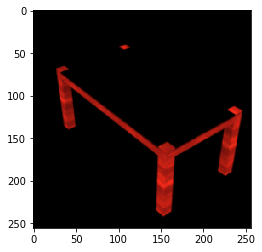

In [85]:
path = os.path.join("/home/max/shapenet", 'train_rgb', 'table_98_render_4.png')
img = data_util.load_img(path, square_crop=True, downsampling_order=1, target_size=[256, 256])
plt.imshow(img[:,:,:3])

In [86]:
x= cv2.imread(path, cv2.IMREAD_UNCHANGED)
y = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
z = cv2.cvtColor(x[:,:,:3], cv2.COLOR_BGR2RGB)
z.shape

(224, 224, 3)

In [87]:
img.shape

(256, 256, 3)

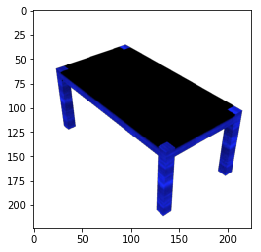

In [88]:
plt.imshow(x)

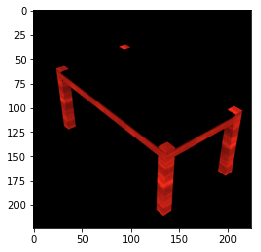

In [89]:
plt.imshow(y)

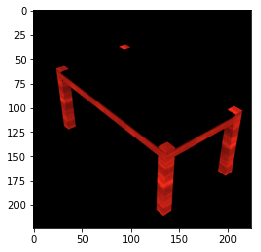

In [90]:
plt.imshow(z)

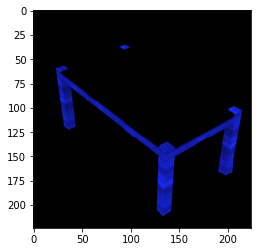

In [91]:
plt.imshow(x[:,:,:3])

In [92]:
z[0,0]

array([0, 0, 0], dtype=uint8)

In [93]:
x[0,0]

array([0, 0, 0, 0], dtype=uint8)

In [94]:
path1 = os.path.join("/home/max/cars_new", 'train_rgb', 'car_100_000005.png')
x1= cv2.imread(path1, cv2.IMREAD_UNCHANGED)

In [95]:
x1[0,0]

array([255, 255, 255, 255], dtype=uint8)

In [96]:
x[(x == np.array([0, 0, 0, 0])).all(axis=-1)] = np.array([255, 255, 255, 255])

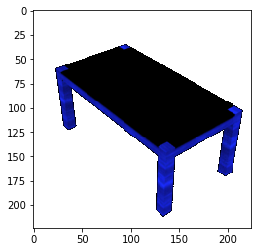

In [97]:
plt.imshow(x[:,:,:3])

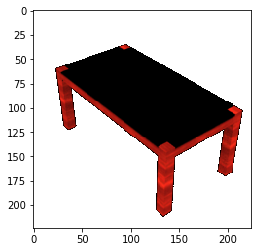

In [98]:
y = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
plt.imshow(y)

In [99]:
y[0,0]

array([255, 255, 255], dtype=uint8)